In [34]:
import pandas as pd
from example.nuscenes.av_discretizer  import AVDiscretizer
from example.nuscenes.transition import TransitionRecorded
from nuscenes import NuScenes
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
import example.nuscenes.environment as env


In [35]:
# This is the path where you stored your copy of the nuScenes dataset.

DATAROOT = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
#nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)
nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
85 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 72.620 seconds.
Reverse indexing ...
Done reverse indexing in 6.4 seconds.


# Data Analysis


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

# Load the CSV data into a DataFrame


In [58]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}

df = pd.read_csv(DATAROOT / 'dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])

#df = pd.read_csv('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes/dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])




df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:30.048445,"[0.2766247744031405, -0.0027369692279543625, 0...",427.968589,1622.155824,0.0,2.581053,0.000018,0.000028,0.000212,0.000000e+00,0.000000
1,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:30.548859,"[0.27663215946727443, -0.002737971665731827, 0...",427.968593,1622.155822,0.0,2.581038,0.000008,-0.000020,-0.000031,-7.657486e-11,-0.000004
2,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.048731,"[0.27662503731230986, -0.002729398219646146, 0...",427.968591,1622.155823,0.0,2.581052,0.000004,-0.000008,0.000029,7.038325e-10,0.000002
3,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.448537,"[0.2766891809143752, -0.0027446222315419917, 0...",427.968585,1622.155827,0.0,2.580919,0.000018,0.000036,-0.000334,9.009808e-10,0.000007
4,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.948403,"[0.276690691475819, -0.002853827740243303, 0.0...",427.968578,1622.155832,0.0,2.580916,0.000017,-0.000003,-0.000005,-5.687954e-10,0.000009


In [59]:
df.shape

(32449, 13)

### Compute deltas for relevant columns

In [86]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
delta_df = pd.DataFrame()
delta_df['x_diff'] = df.groupby('scene_token')['x'].diff()
delta_df['y_diff'] = df.groupby('scene_token')['y'].diff()
delta_df['z_diff'] = df.groupby('scene_token')['z'].diff()
delta_df['velocity_diff'] = df.groupby('scene_token')['velocity'].diff()
delta_df['acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff()
delta_df['yaw_diff'] = df.groupby('scene_token')['yaw'].diff()
delta_df['heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff()


In [87]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
abs_df = pd.DataFrame()
abs_df['abs_x_diff'] = df.groupby('scene_token')['x'].diff().abs()
abs_df['abs_y_diff'] = df.groupby('scene_token')['y'].diff().abs()
abs_df['abs_z_diff'] = df.groupby('scene_token')['z'].diff().abs()
abs_df['abs_velocity_diff'] = df.groupby('scene_token')['velocity'].diff().abs()
abs_df['abs_acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff().abs()
abs_df['abs_yaw_diff'] = df.groupby('scene_token')['yaw'].diff().abs()
abs_df['abs_heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff().abs()


### Compute statistics to understand their distribution

Original Dataset

In [88]:
stats = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].describe()
stats.loc[['mean', 'std', 'min', 'max']]

,velocity,acceleration,yaw,heading_change_rate
mean,5.091121,0.004636,0.222662,0.000734
std,3.596475,0.647916,1.836088,0.778293
min,0.000000,-4.839118,-3.141337,-15.664581
max,18.439187,3.383211,3.140702,15.413213


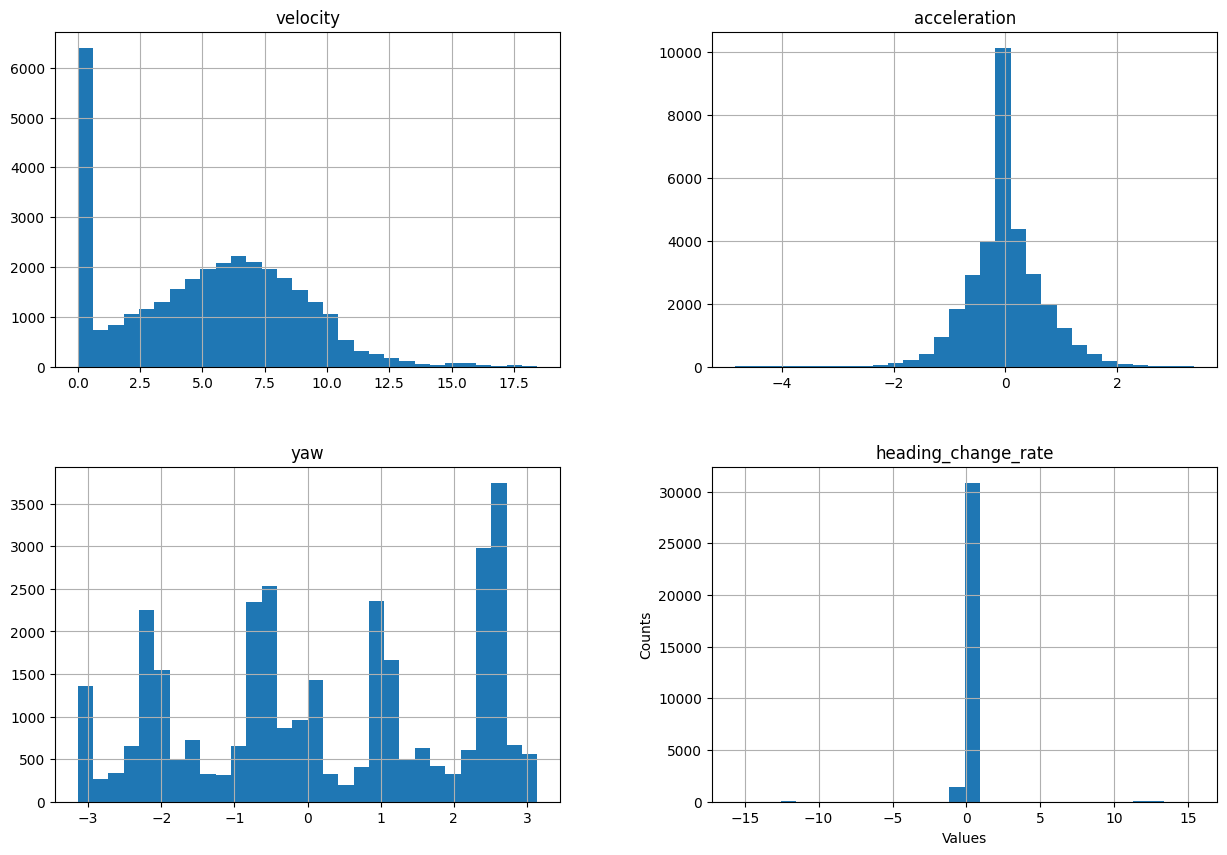

In [89]:
df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation matrix

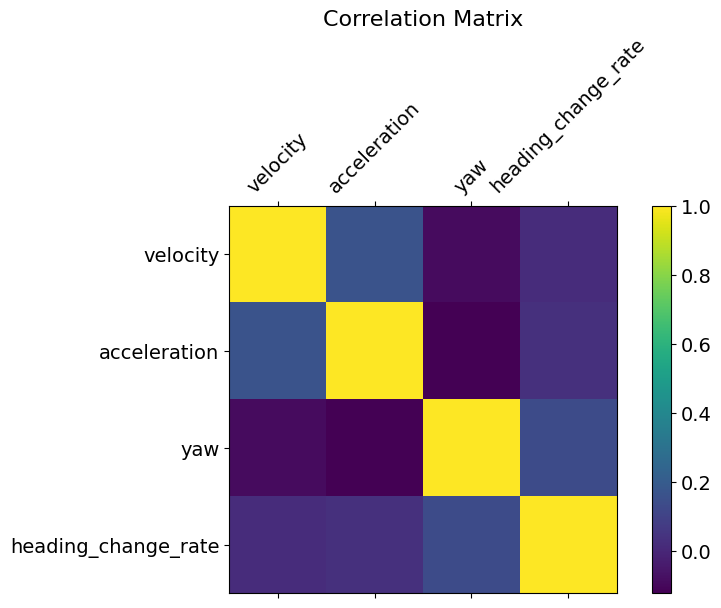

In [42]:
f = plt.figure(figsize=(9, 5))
numeric_df = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']]
plt.matshow(numeric_df.corr(), fignum=f.number)
plt.xticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Variation  Dataset

In [90]:
stats = delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].describe()
stats.loc[['mean', 'std', 'min', 'max']]


,x_diff,y_diff,z_diff,velocity_diff,acceleration_diff,yaw_diff,heading_change_rate_diff
mean,0.015563,0.005099,0.0,0.001969,-0.001040,0.000183,0.000501
std,2.326770,2.071664,0.0,0.322763,0.420486,0.388615,1.138504
min,-6.781485,-7.394914,0.0,-2.418950,-4.843464,-6.280909,-25.112800
max,8.450918,6.814903,0.0,1.695012,3.209952,6.279785,15.763745


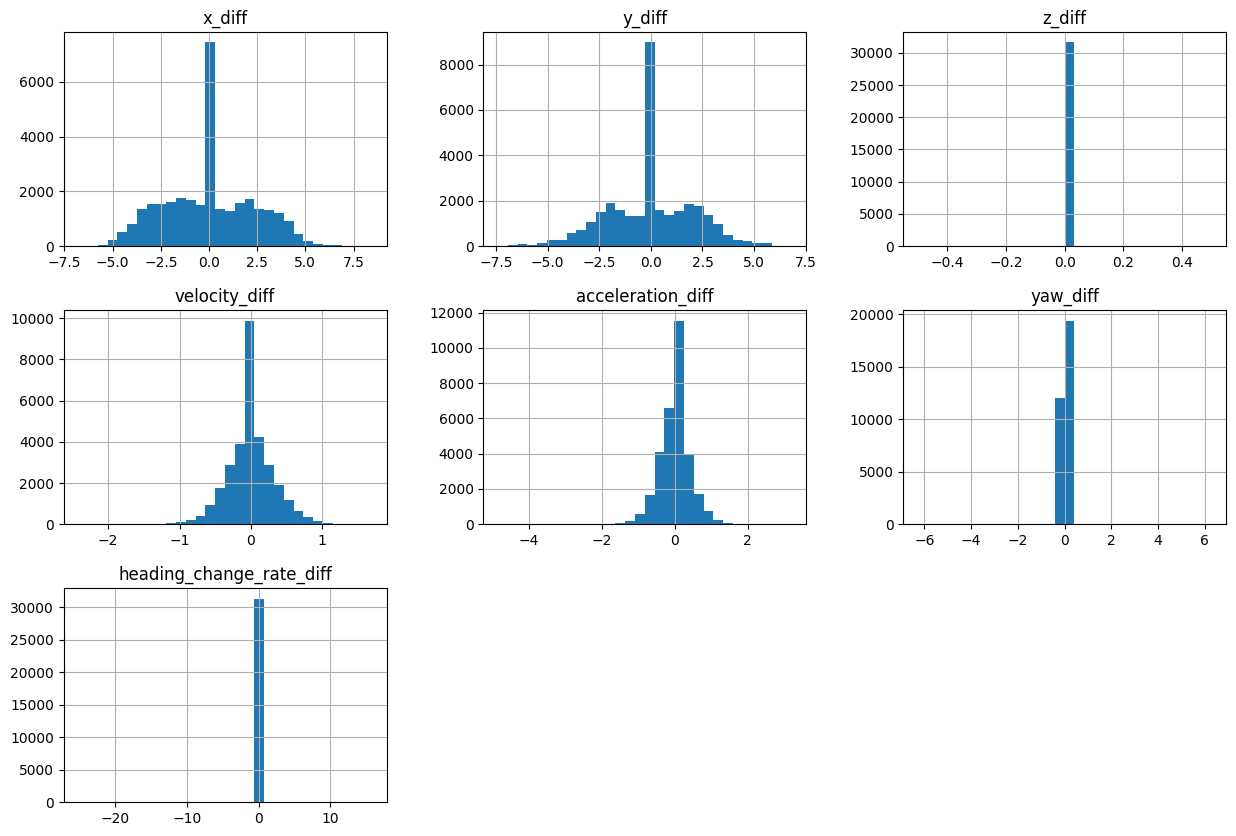

In [91]:
delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation Matrix


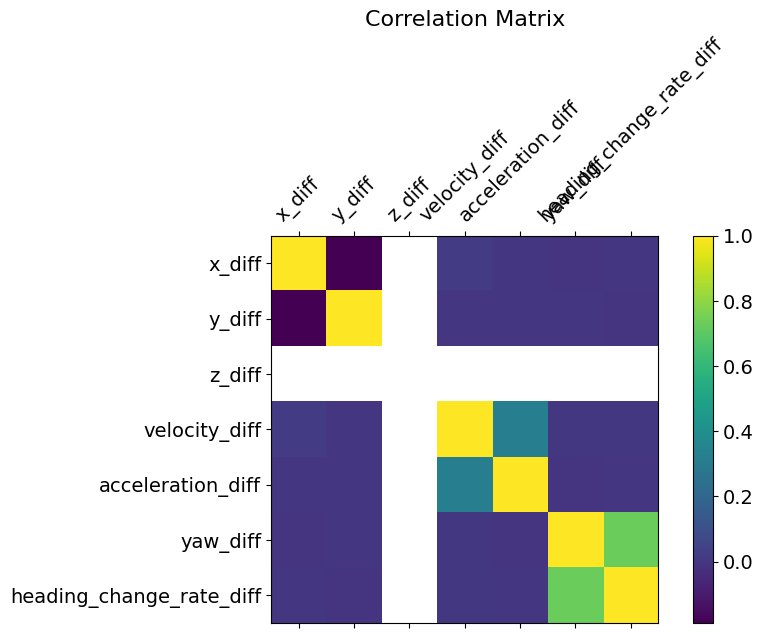

In [92]:
f = plt.figure(figsize=(9, 5))
plt.matshow(delta_df.corr(), fignum=f.number)
plt.xticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Absolute Variation Dataset

In [93]:
abs_stats = abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].describe()
abs_stats.loc[['mean', 'std', 'min', 'max']]


,abs_x_diff,abs_y_diff,abs_z_diff,abs_velocity_diff,abs_acceleration_diff,abs_yaw_diff,abs_heading_change_rate_diff
mean,1.789415,1.527369,0.0,0.225481,0.291673,4.269880e-02,1.109678e-01
std,1.487278,1.399603,0.0,0.230947,0.302876,3.862625e-01,1.133083e+00
min,0.000000,0.000000,0.0,0.000000,0.000000,1.048140e-11,1.233002e-11
max,8.450918,7.394914,0.0,2.418950,4.843464,6.280909e+00,2.511280e+01


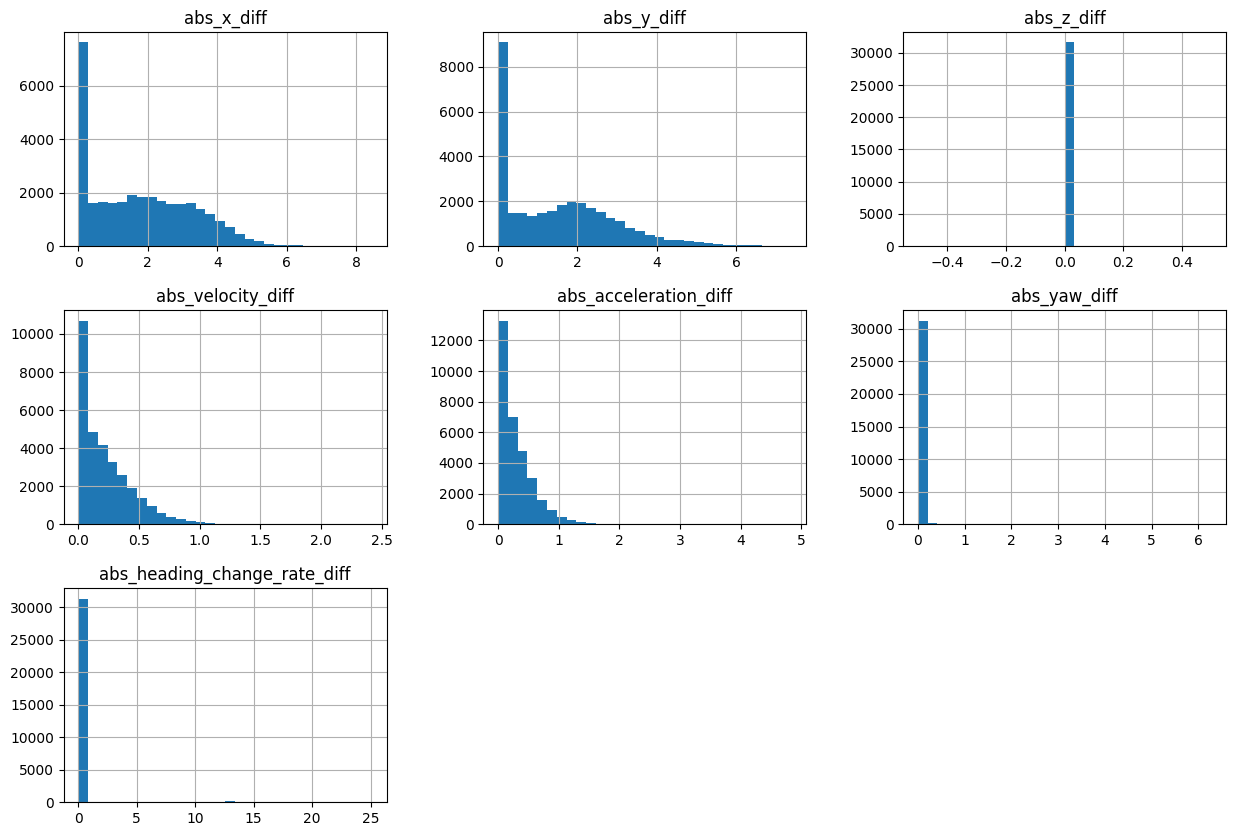

In [94]:
abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Interpretation:
- x_diff:
- y_diff:
Since these have broader distributions, setting a threshold might require considering the context of the movement. If you're looking to detect significant lateral movements (e.g., lane changes), you might set a threshold around the higher frequency lower-end values.

- z_diff: The z differences are concentrated near zero with a very sharp peak, indicating that there is very little change in the vertical position, which is expected for a vehicle traveling on relatively flat surfaces. (0.05-0.1)


- velocity_diff: high concentration at the lower end, suggesting that velocity changes between consecutive measurements are generally small, with occasional larger changes.
    Plausible threshold to detect meaningful acceleration or deceleration might be set just above the most frequent low-end changes, possibly in the range where the histogram bars start to significantly lower. (0.1-0.2 m/s)


- acceleration_diff: most acceleration changes are close to zero, with a few instances of larger differences. This pattern is typical for driving in urban environments, where acceleration and deceleration are frequent but not extreme. Threshold might be set at a value that excludes the majority of these minor changes but captures the less frequent larger changes. (5-10)


- yaw_diff: histogram is highly skewed towards smaller values, indicating that most of the time, there are only slight changes in orientation, which corresponds to driving mostly straight with occasional turns. (0.1-0.2)


- heading_change_rate_diff:Similar to yaw_diff, the histogram for heading change rate differences is skewed towards smaller values. The vehicle mostly maintains its heading with only slight variations within the sampled timeframe. (0.01-0.02)



# Determine Trajectory in Scene's Instances

In [48]:
# Initialize your AVDiscretizer
av_discretizer = AVDiscretizer()


### Let's do an example of computing trajectory of an instance of a scene. We then check if the images of the instace match the actions in the trajectory.

In [61]:
df['scene_token'].unique()

array(['0053e9c440a94c1b84bd9c4223efc4b0',
       '00590cbfa24a430a8c274b51e1c71231',
       '010fb5bcc7984d0f8f07f99e02366df1',
       '01452fbfbf4543af8acdfd3e8a1ee806',
       '01796494e25c448dadaba70cfcc3532d',
       '019b370afb444a2e8ce85654898307c8',
       '01c3f5e39956402da3e37845632fadca',
       '01c8c59260db4a3682d7b4f8da65425e',
       '01e4fcbe6e49483293ce45727152b36e',
       '0287702725184161af95373198546a59',
       '02e484442a2f411b971edcf96ebbe885',
       '02f1e5e2fc544798aad223f5ae5e8440',
       '034256c9639044f98da7562ef3de3646',
       '034dee1695304630b0692da8c1f153fc',
       '03a8a37d5d444674bae34336e78ac39d',
       '03ee880dd4e348f4b3407f0d073c7c70',
       '04061484361145f5ac6f90a5103b84a6',
       '04219bfdc9004ba2af16d3079ecc4353',
       '04e5f089805540a5a9e73c1b7c54ee8c',
       '055a607b74e04001adef097225a8661a',
       '05d5241d4d5a4c2a9c670dc8c9853c74',
       '06c43bc74aff453081ce83eb126a756e',
       '078e6d7a3d4a429bba404bf12c7a98f2',
       '07a

Select a scene and test the  algorithm


In [82]:
scene_test = '73030fb67d3c46cfb5e590168088ae39'
instance1_example_df = df[df['scene_token']==scene_test]
instance1_example_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
14750,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:11.450214,"[-0.6229050812779672, -0.0072601945295160545, ...",1010.029253,614.858429,0.0,1.796632,3.946719,-0.458842,0.382133,0.000000,0.000000
14751,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:11.950107,"[-0.5474326451039343, -0.008368441278104845, 0...",1009.423492,616.758643,0.0,1.982959,3.989719,0.086017,0.372733,-0.164882,1.987605
14752,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:12.449967,"[-0.46151513479126555, -0.007291877027291194, ...",1008.359039,618.662797,0.0,2.182190,4.364185,0.749143,0.398575,-0.212525,2.171105
14753,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:13.049931,"[-0.3765877759172991, -0.005510969082644358, 0...",1006.588808,620.729597,0.0,2.369440,4.535743,0.285947,0.312102,-0.263189,2.708525
14754,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:13.550364,"[-0.34755873900202205, -0.004512031240647073, ...",1004.701847,622.473983,0.0,2.431744,5.135010,1.197497,0.124501,-0.066797,2.568860
14755,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:13.950168,"[-0.3423204789171903, -0.005776207019009683, 0...",1003.027296,623.908059,0.0,2.442912,5.514448,0.949060,0.027935,-0.003647,2.204695
14756,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:14.449471,"[-0.3437525136718339, -0.003609538800257981, 0...",1000.889972,625.731759,0.0,2.439837,5.627110,0.225639,-0.006160,0.021649,2.809550
14757,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:14.949354,"[-0.3433798713871016, -0.00038056371518957076,...",998.647165,627.648310,0.0,2.440607,5.901670,0.549249,0.001541,0.015822,2.950102
14758,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:15.448683,"[-0.34445165176993164, 0.0012695393777490795, ...",996.399208,629.583279,0.0,2.438307,5.940059,0.076880,-0.004607,0.028850,2.965903
14759,lidar,73030fb67d3c46cfb5e590168088ae39,2018-07-18 03:12:15.948561,"[-0.344073526470217, 0.0045604534669501035, 0....",994.177849,631.493811,0.0,2.439025,5.861317,-0.157522,0.001438,0.020588,2.929871


In [102]:
instance1_example_df['rotation'].tolist()

['[-0.6229050812779672, -0.0072601945295160545, 0.007453462292491267, -0.7822282244929156]',
 '[-0.5474326451039343, -0.008368441278104845, 0.007249920184097388, -0.8367764975920444]',
 '[-0.46151513479126555, -0.007291877027291194, 0.007007292534974888, -0.887074690620439]',
 '[-0.3765877759172991, -0.005510969082644358, 0.009470854066716718, -0.9263161334947587]',
 '[-0.34755873900202205, -0.004512031240647073, 0.010644845460718276, -0.9375869302536834]',
 '[-0.3423204789171903, -0.005776207019009683, 0.010545970283156176, -0.9395063105999693]',
 '[-0.3437525136718339, -0.003609538800257981, 0.00945442598240026, -0.939005747800986]',
 '[-0.3433798713871016, -0.00038056371518957076, 0.011110282520503926, -0.9391308112929483]',
 '[-0.34445165176993164, 0.0012695393777490795, 0.013485577390825348, -0.9387063369686868]',
 '[-0.344073526470217, 0.0045604534669501035, 0.010832776410590843, -0.9388691397643032]',
 '[-0.3439727237606584, 0.0030109717464176754, 0.01095793290504516, -0.9389108

I compute the trajectoy of the scene. Theb, for each sample in the scene, I retrive the images :

In [83]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(instance1_example_df)
# After processing all trajectories:
TransitionRecorded.process_and_save_transitions(trajectory, av_discretizer.unique_states)

State 0: [0.0, 0.0, 3.946719211606506, 1.796631922286363, 0.3821328977536487, -0.4588422007356868, Timestamp('2018-07-18 03:12:11.450214')]
Discretized state: 0 [(252, 153)]&[<Velocity.LOW: 2>]&[<Rotation.SLIGHT_RIGHT: 4>]
Action: {<Action.TURN_LEFT: 2>}

State 1: [-0.1648821641824666, 1.987605174446901, 3.9897185292609065, 1.9829585199818147, 0.3727329602443959, 0.0860170429559937, Timestamp('2018-07-18 03:12:11.950107')]
Discretized state: 1 [(252, 154)]&[<Velocity.LOW: 2>]&[<Rotation.SLIGHT_RIGHT: 4>]
Action: {<Action.GAS: 4>, <Action.TURN_LEFT: 2>}

State 2: [-0.2125246437603576, 2.1711045422095125, 4.364185027992588, 2.182190090204396, 0.3985747413727456, 0.7491427574354443, Timestamp('2018-07-18 03:12:12.449967')]
Discretized state: 2 [(252, 154)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.TURN_LEFT: 2>}

State 3: [-0.2631891626913958, 2.708525426938648, 4.535743002082555, 2.36943975952698, 0.3121015082948051, 0.28594711364343, Timestamp('2018-07-18 03:12:13.04993

Plot trend of state in time for each instance of a scene.

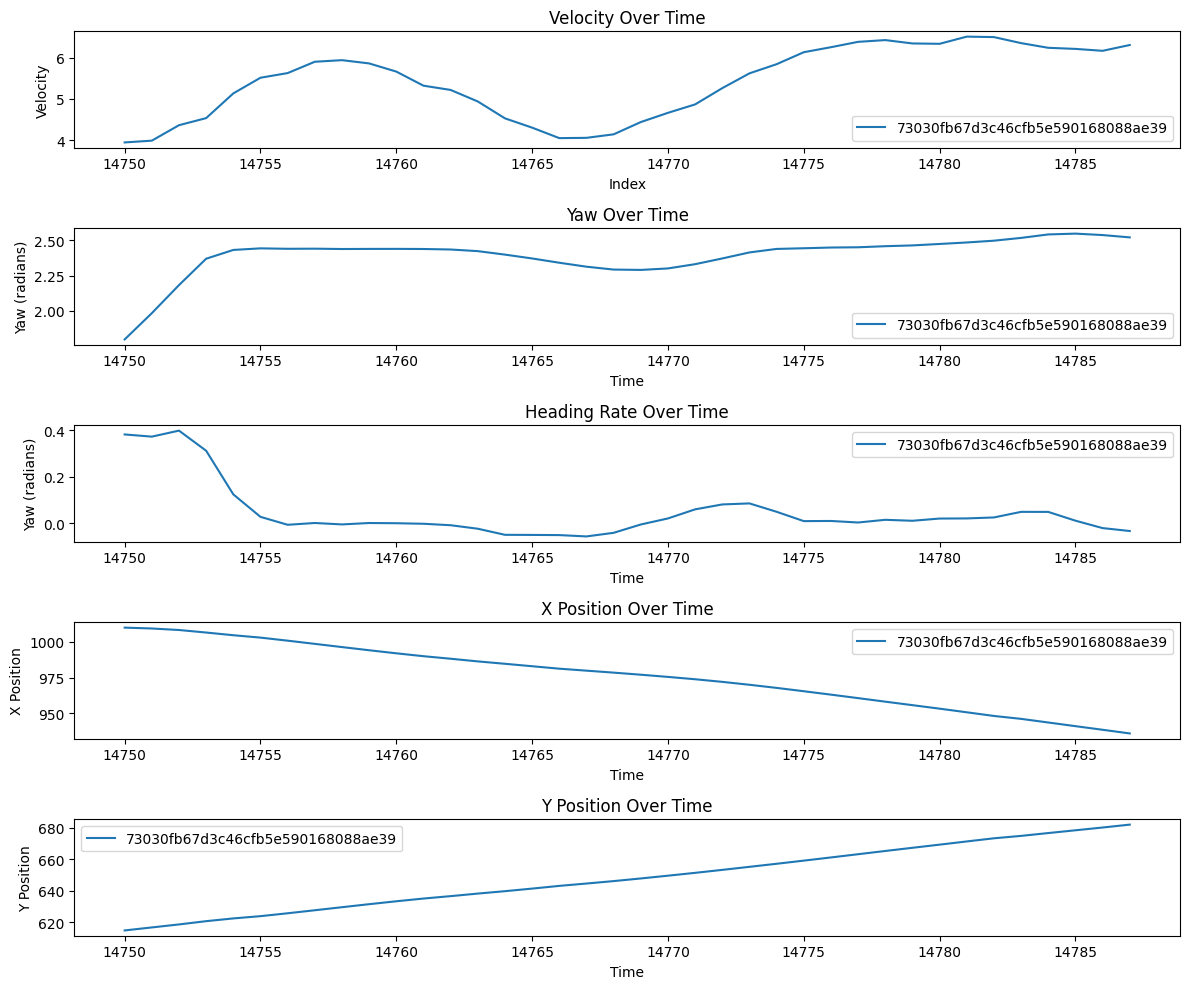

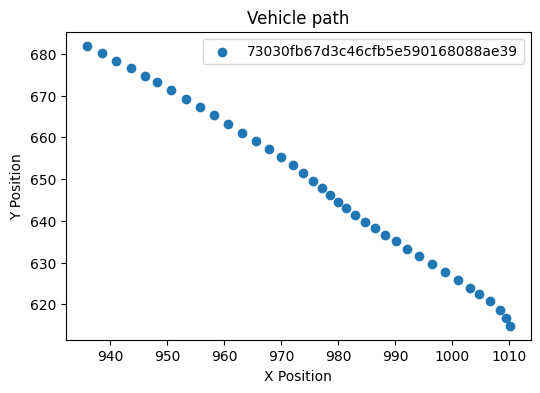

In [105]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=instance_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=instance_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=instance_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=instance_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=instance_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=instance_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [85]:
nuscenes.render_scene(scene_test)



## All scenes trajectory information


Now, apply the above to all scenes in mini dataset.

In [81]:
av_discretizer = AVDiscretizer()
trajectory = av_discretizer.compute_trajectory(df)
TransitionRecorded.process_and_save_transitions(trajectory, av_discretizer.unique_states, path='/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes/')

State 0: [0.0, 0.0, 1.794926330386777e-05, 2.581053162823832, 0.0002123908612616, 2.83357501223882e-05, Timestamp('2018-07-27 16:20:30.048445')]
Discretized state: 0 [(106, 405)]&[<Velocity.STOPPED: 1>]&[<Rotation.RIGHT: 5>]
Action: {<Action.IDLE: 1>}

State 1: [-7.657486360657406e-11, -4.001429546259191e-06, 7.996238208746944e-06, 2.581037774477532, -3.075123057995707e-05, -1.9889581616663057e-05, Timestamp('2018-07-27 16:20:30.548859')]
Discretized state: 1 [(106, 405)]&[<Velocity.STOPPED: 1>]&[<Rotation.RIGHT: 5>]
Action: {<Action.IDLE: 1>}

State 2: [7.038325221624372e-10, 1.9356216942730257e-06, 3.872234936618039e-06, 2.5810523395775187, 2.913765921384072e-05, -8.250118574612911e-06, Timestamp('2018-07-27 16:20:31.048731')]
Discretized state: 2 [(106, 405)]&[<Velocity.STOPPED: 1>]&[<Rotation.RIGHT: 5>]
Action: {<Action.IDLE: 1>}

State 3: [9.009808237637043e-10, 7.375278648924316e-06, 1.8447143624551032e-05, 2.5809187790899237, -0.0003340632396596, 3.645495237173277e-05, Timestamp

KeyboardInterrupt: 

# Policy Graph Generation

In [68]:
path_pg_data = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
env = env.SelfDrivingEnvironment(0,0,0,0)

AttributeError: 'SelfDrivingEnvironment' object has no attribute 'SelfDrivingEnvironment'

In [69]:
av_discretizer = AVDiscretizer()

pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

{0: {'value': ((106, 405), <Velocity.STOPPED: 1>, <Rotation.RIGHT: 5>), 'probability': 0.0013868343195266271, 'frequency': 45}, 1: {'value': ((106, 405), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>), 'probability': 0.00043145956607495067, 'frequency': 14}, 2: {'value': ((105, 405), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>), 'probability': 0.0001849112426035503, 'frequency': 6}, 3: {'value': ((105, 406), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>), 'probability': 0.00040064102564102563, 'frequency': 13}, 4: {'value': ((104, 406), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>), 'probability': 0.0001849112426035503, 'frequency': 6}, 5: {'value': ((104, 407), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>), 'probability': 0.00027736686390532545, 'frequency': 9}, 6: {'value': ((104, 407), <Velocity.LOW: 2>, <Rotation.SLIGHT_RIGHT: 4>), 'probability': 0.00015409270216962525, 'frequency': 5}, 7: {'value': ((104, 408), <Velocity.LOW: 2>, <Rotation.SLIGHT_RIGHT: 4>), 'probability': 0.0005547337278106509, 'frequency': 18

In [71]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 14951
Number of edges: 23048


In [72]:
arbitrary_state = list(pg.nodes)[0]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

((106, 405), <Velocity.STOPPED: 1>, <Rotation.RIGHT: 5>)
  Times visited: 45
  p(s):          0.001


In [73]:
arbitrary_edge = list(pg.edges)[0]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    ((106, 405), <Velocity.STOPPED: 1>, <Rotation.RIGHT: 5>)
Action:  0
To:      ((106, 405), <Velocity.STOPPED: 1>, <Rotation.RIGHT: 5>)
  Times visited:      43
  p(s_to,a | s_from): 0.956


In [74]:
len(pg._trajectories_of_last_fit)


0